In [3]:
import pandas as pd
import math
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from string import punctuation
import nltk
from mpl_toolkits.mplot3d import Axes3D
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Choose the news group:

In [4]:
news_group="sci.med"



'alt.atheism',

 'comp.graphics',
 
 'comp.os.ms-windows.misc',
 
 'comp.sys.ibm.pc.hardware',
 
 'comp.sys.mac.hardware',
 
 'misc.forsale',
 
 'rec.autos',
 
 'rec.motorcycles',
 
 'rec.sport.baseball',
 
 'rec.sport.hockey',
 
 'sci.crypt',
 
 'sci.electronics',
 
 'sci.med',
 
 'sci.space',
 
 'soc.religion.christian',
 
 'talk.politics.guns',
 
 'talk.politics.mideast',
 
 'talk.politics.misc',
 
 'talk.religion.misc'

# Loading data and creating bag of words :

In [5]:

n_docs=40
categories = [news_group]

twenty_train = fetch_20newsgroups(subset='train',
        categories=categories,
        remove=('headers', 'footers', 'quotes'),
        shuffle=True)


stopwords = nltk.corpus.stopwords.words('english')
def strip_punctuation(s):
    return ''.join(c for c in s if c not in punctuation)
def strip_nums(s):
    return ''.join([i for i in s if not i.isdigit()])

#all_docs=[nltk.tokenize.wordpunct_tokenize(strip_punctuation(twenty_train.data[i]).lower()) for i in range(n_docs)]
all_docs=[nltk.tokenize.wordpunct_tokenize(strip_nums(strip_punctuation(twenty_train.data[i]).lower())) for i in range(n_docs)]


bow=[[i for i in all_docs[j] if i not in stopwords] for j in range(n_docs)]


bow=list(filter(None,bow))


## Creating tf-idf matrix :

In [6]:

def unique(bow):
    a = bow[0]
    for i in range(1,len(bow)):
        a = set(a).union(set(bow[i]))
    return a


wordset = unique(bow)
worddict = [dict.fromkeys(wordset,0) for i in range(len(bow))]


def term_document_matrix():
    
    for bow_i,worddict_i in zip(bow,worddict):
        for word in bow_i:
                    worddict_i[word]+=1
    return pd.DataFrame(worddict)


docterm = term_document_matrix()


def term_freq(worddict,bow):
    tfdict = {}
    bowcount = len(bow)
    for word,count in worddict.items():
        
        tfdict[word] = count/float(bowcount)
    return tfdict


tfbow =[term_freq(i,j) for i,j in zip(worddict,bow)]


def idf(doclist):
    idfdict={}
    n = len(doclist)
    
    idfdict = dict.fromkeys(doclist[0].keys(),0)
    for doc in doclist:
        for word,val in doc.items():
            if val>0:
                idfdict[word]+=1
    for word,val in idfdict.items():
        idfdict[word]=math.log(n/float(val))
    return idfdict


idfs = idf(worddict) 

def tfidf(tfbow,idfs):
    tfidf = {}
    for word,val in tfbow.items():
        tfidf[word]=val*idfs[word]
    return tfidf

tfidf = [tfidf(i,idfs) for i in tfbow]  

X = pd.DataFrame(tfidf).T

L,S,R=np.linalg.svd(X)



# Functions for search, low rank approximation, plotting documents, printing concepts:

In [7]:
def top_n_pad_0(U,S,V,n):
    t=list(S[:n])
    for i in range(len(S)-n):
        t.append(0) 
    A = np.diag(t)
    newrow= [0]*len(S)
    if len(U)>len(V):
        for i in range(len(U)-len(S)):
            A=np.vstack([A, newrow]) 
        return A
    else:
        for i in range(len(V)-len(S)):
            A=np.vstack([A.T, newrow]).T  
        return A
        
def reconstruct(u,s,v,n):
    A=top_n_pad_0(u,s,v,n)
    return np.round((u.dot(A)).dot(v),decimals=3)
def frobenius(a,a2):
    a =np.array(a)

    return (np.sqrt(np.sum((a-a2)**2)))/np.sqrt(np.sum(a**2))

def find_k():

    for i in range(1,len(S)):
        f=frobenius(X,reconstruct(L,S,R,i))
        #print(f)
        if f<0.38:
            return i


def search(q):
    q=strip_punctuation(q)
    q=q.lower().split(" ")
    terms = X.index
    query=np.array([1 if i in q else 0 for i in terms])
    if np.count_nonzero(query==1)==0:
        print("Keywords don't match with documents")
    else:
        score = query.dot(reconstruct(L,S,R,find_k()))
        sort = sorted(zip(range(1,len(score)+1),score),key=lambda x:x[1],reverse=True)

        for i in range(len(sort)):
            print("Document-{}".format(sort[i][0]))
        
def print_concepts(n_concepts,n_keywords):
    terms = X.index
    for i,component in enumerate(L.T[:n_concepts]):
        y = zip(terms,component)
        z=sorted(y,key = lambda x:x[1],reverse=True)[:n_keywords]
        print("concept %d:"%(i+1))
        for i in z:
            print(i[0])
            print(" ")
            
def print_concept_docs(n_docs):
    cols = X.columns
    for i,component in enumerate(R):
        y = zip(cols,component)
        z=sorted(y,key = lambda x:x[1],reverse=True)[:n_docs]
        print("Docs which contain most important concepts %d:"%(i+1))
        for i in z:
            print(i[0])
            print(" ")
            
def plot_docs_3d():
    y=R.T.dot(np.diag(S))
    c = list(y[1])
    d = list(y[2])
    e = list(y[3])
    fig = pylab.figure()
    ax = fig.add_subplot(111, projection = '3d')

    sc = ax.scatter(c,d,e)
    # for i, docs in enumerate(cols):
    #     ax.text(c[i],d[i],e[i],  '%s' % (str(i)), size=20, zorder=1,color='k') 
    for x,y,z,i in zip(c,d,e,range(len(c))):
        ax.text(x,y,z,i)
    plt.xlabel("concept 1")
    plt.ylabel("concept 2")
    
    
        
def plot_docs_2d():
    y=R.T.dot(np.diag(S))
    c = list(y[1])
    d = list(y[2])

    fig = pylab.figure()
    ax = fig.add_subplot(111)

    sc = ax.scatter(c,d)

        # for i, docs in enumerate(cols):
        #     ax.text(c[i],d[i],e[i],  '%s' % (str(i)), size=20, zorder=1,color='k') 
    for x,y,i in zip(c,d,range(len(c))):
        ax.text(x,y,i)
        plt.xlabel("concept 1")
        plt.ylabel("concept 2")

## Pass the query into the search function, to get the list of relevant documents.
## Pass a query related to the news group for better relevance.

In [8]:
search("Sky is high.")

Document-15
Document-2
Document-4
Document-32
Document-14
Document-23
Document-29
Document-21
Document-3
Document-5
Document-6
Document-8
Document-22
Document-38
Document-39
Document-1
Document-9
Document-10
Document-11
Document-12
Document-13
Document-16
Document-17
Document-18
Document-19
Document-20
Document-24
Document-26
Document-27
Document-28
Document-30
Document-31
Document-33
Document-34
Document-35
Document-36
Document-40
Document-25
Document-37
Document-7


## Plotting the documents in a 2d ->(concept1,concept2)  space.

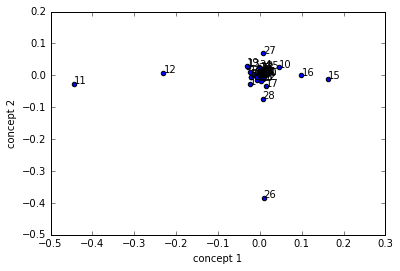

In [9]:
plot_docs_2d()



## Plotting the documents in a 3d ->(concept1,concept2,concept3)  space.

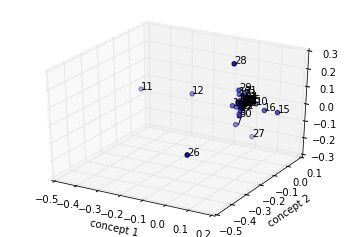

In [10]:
plot_docs_3d()

## Print the keywords that describe the most important concepts discussed in the corpus.
## print_concepts(number of concepts, number of keywords for each concept)

In [11]:
print_concepts(5,10)

concept 1:
melittin
 
methodology
 
legal
 
lyme
 
foundation
 
references
 
tb
 
science
 
source
 
done
 
concept 2:
melittin
 
affected
 
aid
 
air
 
appeared
 
attacking
 
benefit
 
block
 
booth
 
caused
 
concept 3:
knots
 
break
 
certain
 
exactly
 
helpful
 
kinds
 
massage
 
sore
 
spots
 
tight
 
concept 4:
knots
 
break
 
certain
 
exactly
 
helpful
 
kinds
 
massage
 
sore
 
spots
 
tight
 
concept 5:
hypothesis
 
anectdotal
 
carl
 
combined
 
constructed
 
disproving
 
events
 
experiment
 
explanation
 
lack
 


## Print the docs that describe the most important concepts discussed in the corpus.
## print_concepts_docs(number of documents per concept)

In [12]:
print_concept_docs(2)

Docs which contain most important concepts 1:
18
 
36
 
Docs which contain most important concepts 2:
18
 
19
 
Docs which contain most important concepts 3:
25
 
27
 
Docs which contain most important concepts 4:
25
 
23
 
Docs which contain most important concepts 5:
32
 
31
 
Docs which contain most important concepts 6:
32
 
9
 
Docs which contain most important concepts 7:
12
 
14
 
Docs which contain most important concepts 8:
12
 
30
 
Docs which contain most important concepts 9:
39
 
33
 
Docs which contain most important concepts 10:
39
 
12
 
Docs which contain most important concepts 11:
35
 
6
 
Docs which contain most important concepts 12:
35
 
33
 
Docs which contain most important concepts 13:
36
 
0
 
Docs which contain most important concepts 14:
27
 
28
 
Docs which contain most important concepts 15:
29
 
28
 
Docs which contain most important concepts 16:
1
 
35
 
Docs which contain most important concepts 17:
19
 
1
 
Docs which contain most important concepts 18